In [1]:
import os
import itertools
import warnings
warnings.filterwarnings('ignore')
import time
import datetime
from datetime import timedelta, datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [20, 8]
plt.rcParams['figure.dpi'] = 100

# pandas max row 
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000

In [2]:
data = pd.read_csv('total_data.csv')
data.columns = ['datetime','solar_result','temp','rain_t','rain_r',
                    'hum','wins', 'wind','sky','altitude','azimuth','altitude_m','azimuth_m']
data['datetime'] = pd.to_datetime(data['datetime'], format = '%Y%m%d%H')
data = data.set_index('datetime',drop=True)
data.head()

,solar_result,temp,rain_t,rain_r,hum,wins,wind,sky,altitude,azimuth,altitude_m,azimuth_m
datetime,,,,,,,,,,,,
2017-06-01 09:00:00,33.12,21.000000,0.0,0.0,65.000000,2.400000,111.000000,1.0,44.230000,92.420000,48.617684,96.897301
2017-06-01 10:00:00,50.16,21.333333,0.0,0.0,65.000000,2.333333,112.000000,1.0,54.833333,114.446667,60.487336,109.600378
2017-06-01 11:00:00,96.72,21.666667,0.0,0.0,65.000000,2.266667,113.000000,1.0,65.436667,136.473333,71.021213,132.383793
2017-06-01 12:00:00,120.96,22.000000,0.0,0.0,65.000000,2.200000,114.000000,1.0,76.040000,158.500000,76.252859,180.000000
2017-06-01 13:00:00,118.80,21.333333,0.0,0.0,63.333333,2.433333,107.666667,1.0,68.386667,192.333333,71.021213,227.616207


# feature coff

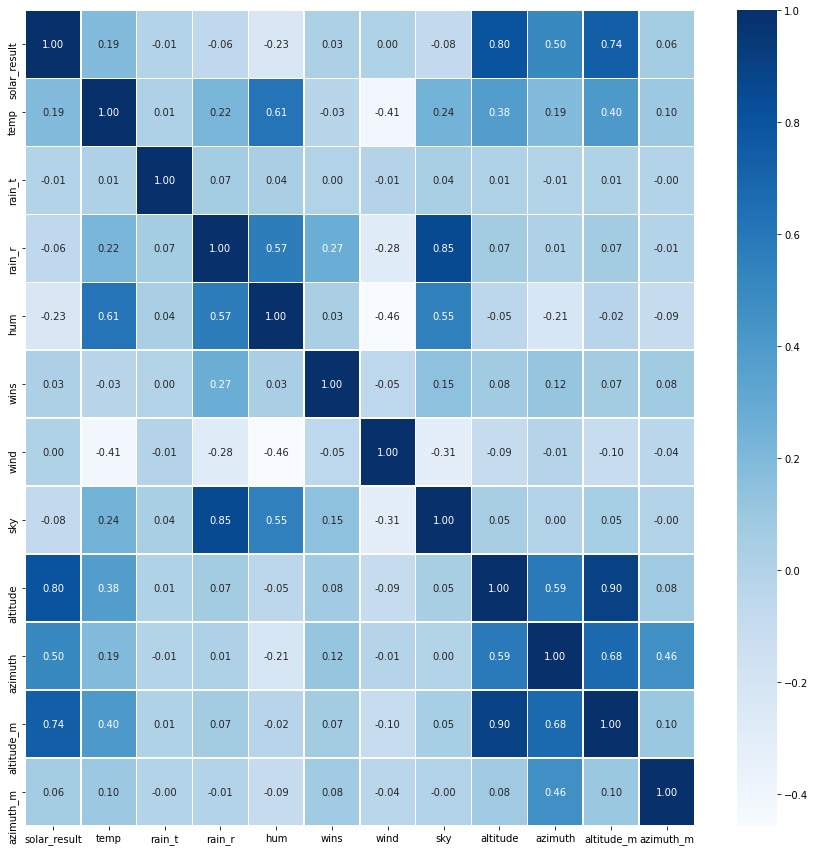

In [4]:
import seaborn as sns
%matplotlib inline
#data['sky*rain_r'] = data['sky']*data['rain_r']
#data['sky*rain_t'] = data['sky']*data['rain_t']
#data['temp*hum'] = data['temp']*data['hum']

plt.figure(figsize=(15,15))
sns.heatmap(data=data.corr(method='pearson'), annot=True,fmt='.2f', linewidths=.5, cmap='Blues')

# LSTM

In [51]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, LSTM, Bidirectional
from keras import backend as K
from sklearn.metrics import mean_squared_error, r2_score

In [52]:
def create_time_steps(length):
    return list(range(-length, 0))

def multivariate_data(dataset1, target, start_index, end_index, history_size, target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset1) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset1[indices])
        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])
    return np.array(data, dtype=np.float), np.array(labels, dtype=np.float)

In [53]:
train_size = int(len(data) * 0.7)
tf.random.set_seed(30)
#standard sacling
dataset_sc = data.values
data_mean = dataset_sc[:train_size].mean(axis=0)
data_std = dataset_sc[:train_size].std(axis=0)
dataset_sc = (dataset_sc - data_mean)/data_std

## model result
1. history = 168</br>
time : 294.253454208374, acc : 0.8737194883934265
2. hitstory = 720</br>
time : 842.6392772197723, acc : 0.8674149419307301

In [7]:
#past_history = [168, 336, 720, 2160] #7일, 30일, 3개월
past_history = [168,720]
batch_size = 64
buffer_size = 10000
evaluation_interval = 10

for i in past_history :
    past_history = i
    future_target = 24
    STEP = 1

    start = time.time()
    x_train_multi, y_train_multi = multivariate_data(dataset_sc, dataset_sc[:, 0], 
                                                     0, train_size, past_history, 
                                                     future_target, STEP)


    x_test_multi, y_test_multi = multivariate_data(dataset_sc, dataset_sc[:, 0], 
                                                   train_size, None, past_history, 
                                                   future_target, STEP)
    
    with tf.device('/device:GPU:0'): 
        multi_step_model = tf.keras.models.Sequential()

        multi_step_model.add(tf.keras.layers.LSTM(32, return_sequences=True, 
                                                  input_shape=x_train_multi.shape[-2:]))
        multi_step_model.add(tf.keras.layers.LSTM(16))
        multi_step_model.add(tf.keras.layers.Dense(future_target))
        multi_step_model.compile(optimizer=tf.keras.optimizers.Adam(clipvalue=1.0),
                                 loss='mse')

        es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, mode='min')
        mc = tf.keras.callbacks.ModelCheckpoint(f'ver2_{i}_best_LSTM.h5',
                                               monitor = 'val_loss', mode='min',
                                               save_best_only = True)
      

    train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
    train_data_multi = train_data_multi.cache().shuffle(buffer_size).batch(batch_size).repeat()

    test_data_multi = tf.data.Dataset.from_tensor_slices((x_test_multi, y_test_multi))
    test_data_multi = test_data_multi.batch(batch_size).repeat() 
    
    multi_step_history = multi_step_model.fit(train_data_multi, epochs=300,
                                              steps_per_epoch=evaluation_interval,
                                              validation_data=test_data_multi,
                                              validation_steps=50,
                                              callbacks=[es, mc])
    
    print("time :", time.time() - start)
    print(r2_score(y_test_multi, multi_step_model.predict(x_test_multi)))


Epoch 1/300
10/10 [==============================] - 10s 129ms/step - loss: 1.0400 - val_loss: 0.8757
Epoch 2/300
10/10 [==============================] - 0s 53ms/step - loss: 0.9594 - val_loss: 0.8405
Epoch 3/300
10/10 [==============================] - 1s 55ms/step - loss: 0.9262 - val_loss: 0.7993
Epoch 4/300
10/10 [==============================] - 0s 54ms/step - loss: 0.8631 - val_loss: 0.7407
Epoch 5/300
10/10 [==============================] - 1s 56ms/step - loss: 0.7750 - val_loss: 0.6653
Epoch 6/300
10/10 [==============================] - 1s 55ms/step - loss: 0.6810 - val_loss: 0.5843
Epoch 7/300
10/10 [==============================] - 1s 54ms/step - loss: 0.5786 - val_loss: 0.5053
Epoch 8/300
10/10 [==============================] - 1s 54ms/step - loss: 0.4851 - val_loss: 0.4364
Epoch 9/300
10/10 [==============================] - 1s 55ms/step - loss: 0.4394 - val_loss: 0.3846
Epoch 10/300
10/10 [==============================] - 1s 55ms/step - loss: 0.4001 - val_loss: 0.34

In [55]:
from tensorflow import keras 
model_168 = keras.models.load_model('/content/ver_168_best_LSTM.h5')
model_720 = keras.models.load_model('/content/ver_720_best_LSTM.h5')

In [56]:
def checking_point(model, history) :
  x_test_multi, y_test_multi = multivariate_data(dataset_sc, dataset_sc[:, 0], 
                                                   train_size, None, history, 
                                                   future_target, STEP)
  prediction = model.predict(x_test_multi)
  df = pd.DataFrame()
  df['y'] = data.iloc[train_size+(history+24):, 0]
  df['yhat'] = prediction[:,0]*data_std[0] + data_mean[0]
  diff = []
  for i in range(len(df)) :
    a,b = df.iloc[i,:2]
    if a < 18.7 :
      diff.append(np.nan)
    else :
      value = abs(a-b)/187*100  #|발전량-예측값|/설비용량*100
      diff.append(value)
  df['diff'] = diff
  return df

In [57]:
def score_every_day(df) :
  df['day'] = df.index.strftime('%Y%m%d')
  df['month'] = df.index.strftime('%Y%m')

In [58]:
batch_size = 64
buffer_size = 10000
evaluation_interval = 10
past_history = 168
future_target = 24
STEP = 1

df168 = checking_point(model_168,168)
df168['day'] = df168.index.strftime('%Y%m%d')
df168['month'] = df168.index.strftime('%Y%m')

df720 = checking_point(model_720,720)
df720['day'] = df720.index.strftime('%Y%m%d')
df720['month'] = df720.index.strftime('%Y%m')

In [15]:
df168['2020-05-01 00:00:00':]

,y,yhat,diff,day,month
datetime,,,,,
2020-05-01 00:00:00,0.0,3.320997,NaN,20200501,202005
2020-05-01 01:00:00,0.0,1.754814,NaN,20200501,202005
2020-05-01 02:00:00,0.0,-2.583042,NaN,20200501,202005
2020-05-01 03:00:00,0.0,-3.715967,NaN,20200501,202005
2020-05-01 04:00:00,0.0,-3.270777,NaN,20200501,202005
...,...,...,...,...,...
2020-06-30 20:00:00,0.0,0.665022,NaN,20200630,202006
2020-06-30 21:00:00,0.0,0.659372,NaN,20200630,202006
2020-06-30 22:00:00,0.0,0.904263,NaN,20200630,202006


In [16]:
df720['2020-05-01 00:00:00':]

,y,yhat,diff,day,month
datetime,,,,,
2020-05-01 00:00:00,0.0,4.946524,NaN,20200501,202005
2020-05-01 01:00:00,0.0,9.024046,NaN,20200501,202005
2020-05-01 02:00:00,0.0,7.512405,NaN,20200501,202005
2020-05-01 03:00:00,0.0,2.989738,NaN,20200501,202005
2020-05-01 04:00:00,0.0,-0.571428,NaN,20200501,202005
...,...,...,...,...,...
2020-06-30 20:00:00,0.0,-3.353464,NaN,20200630,202006
2020-06-30 21:00:00,0.0,-5.571600,NaN,20200630,202006
2020-06-30 22:00:00,0.0,-5.207018,NaN,20200630,202006


In [59]:
! pip install plotly==5.1.0
! pip install cufflinks
! pip install chart_studio
! pip install plotly plotly chart-studio

     |████████████████████████████████| 20.6 MB 64.6 MB/s 
  Attempting uninstall: plotly
    Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1
     |████████████████████████████████| 64 kB 1.7 MB/s 


In [26]:
import plotly.graph_objects as go

resample = df168['2020-05-01 00:00:00':]
resample['720'] = df720['yhat']['2020-05-01 00:00:00':]

f = go.FigureWidget()
f.add_scatter(y=resample['y']['2020-05-01 00:00:00':],x = resample.index, name = 'real_result');
f.add_scatter(y=resample['yhat']['2020-05-01 00:00:00':],x = resample.index,name = 'prediction by 168');
f.add_scatter(y=resample['720']['2020-05-01 00:00:00':],x = resample.index,name = 'prediction by 720');
f.update_layout(plot_bgcolor='white')
f.update_xaxes(showgrid=True, gridwidth=1, gridcolor='LightGrey')
f.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGrey')
f.update_xaxes(zeroline=True, zerolinewidth=1, zerolinecolor='LightGrey')
f.update_yaxes(zeroline=True, zerolinewidth=2, zerolinecolor='LightGrey')

f.show()

# CNN-RNN

In [48]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [80]:
lookback = 720
step = 1
delay = 1
batch_size = 200

train_gen = generator(dataset_sc,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=train_size,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)

test_gen = generator(dataset_sc,
                     lookback=lookback,
                     delay=delay,
                     min_index=train_size+1,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# 전체 테스트 세트를 순회하기 위해 test_gen에서 추출할 횟수
test_steps = (len(dataset_sc) - (train_size+1) - lookback) // batch_size

In [112]:
from keras.models import Sequential
from keras import layers

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, dataset_sc.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=tf.keras.optimizers.Adam(clipvalue=1.0), loss='mae')

mc = tf.keras.callbacks.ModelCheckpoint(f'test_verysimple_model.h5',
                                               monitor = 'val_loss', mode='min',
                                               save_best_only = True)
history = model.fit_generator(train_gen,
                              steps_per_epoch=20,
                              epochs=200,
                              validation_data=test_gen,
                              validation_steps=50,
                              callbacks=mc)

Epoch 1/200
20/20 [==============================] - 33s 150ms/step - loss: 0.6375 - val_loss: 0.3776
Epoch 2/200
20/20 [==============================] - 3s 135ms/step - loss: 0.3127 - val_loss: 0.2535
Epoch 3/200
20/20 [==============================] - 3s 135ms/step - loss: 0.1850 - val_loss: 0.1734
Epoch 4/200
20/20 [==============================] - 3s 135ms/step - loss: 0.1253 - val_loss: 0.1244
Epoch 5/200
20/20 [==============================] - 3s 135ms/step - loss: 0.0976 - val_loss: 0.1071
Epoch 6/200
20/20 [==============================] - 3s 139ms/step - loss: 0.0882 - val_loss: 0.0960
Epoch 7/200
20/20 [==============================] - 3s 135ms/step - loss: 0.0815 - val_loss: 0.1020
Epoch 8/200
20/20 [==============================] - 3s 138ms/step - loss: 0.0785 - val_loss: 0.0876
Epoch 9/200
20/20 [==============================] - 3s 137ms/step - loss: 0.0752 - val_loss: 0.0904
Epoch 10/200
20/20 [==============================] - 3s 136ms/step - loss: 0.0729 - val_l

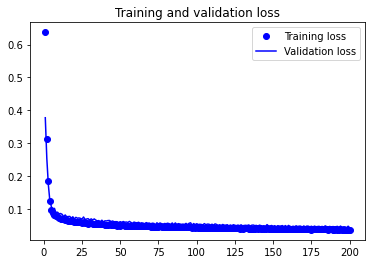

In [113]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [117]:
test = keras.models.load_model('test_verysimple_model.h5')
long_model = keras.models.load_model('/content/test_long_model.h5')

In [119]:
df = checking_point(test, 720)
df_long = checking_point(long_model, 720)

resample = df['2020-05-01 00:00:00':]
resample['long'] = df_long['yhat']['2020-05-01 00:00:00':]

f = go.FigureWidget()
f.add_scatter(y=resample['y']['2020-05-01 00:00:00':],x = resample.index, name = 'real_result');
f.add_scatter(y=resample['yhat']['2020-05-01 00:00:00':],x = resample.index,name = 'long CNN-RNN');
f.add_scatter(y=resample['long']['2020-05-01 00:00:00':],x = resample.index,name = 'simple CNN-RNN');
f.update_layout(plot_bgcolor='white')
f.update_xaxes(showgrid=True, gridwidth=1, gridcolor='LightGrey')
f.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGrey')
f.update_xaxes(zeroline=True, zerolinewidth=1, zerolinecolor='LightGrey')
f.update_yaxes(zeroline=True, zerolinewidth=2, zerolinecolor='LightGrey')

f.show()

# ML

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data.loc[:,'temp':], data.loc[:,'solar_result'], test_size = 0.7, random_state = 42)

In [40]:
train_size = int(len(data) * 0.7)
X_test, y_test = data.iloc[train_size:,1:], data.iloc[train_size:,0]

In [62]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

def svr_gbr(name = '', train_x = '', train_y = '', test_x = '', test_y = '', SVR_C = 1000.0, gbr_n = 300, n_neighbors = 200) :

  svr = make_pipeline(StandardScaler(), SVR(C=SVR_C, epsilon=0.2))
  svr.fit(train_x, train_y)
  print(svr)
  print(f"SVM 훈련 세트 점수: {svr.score(train_x, train_y)} \nSVM 테스트 세트 점수 : {svr.score(test_x, test_y)}")
  gbr = GradientBoostingRegressor(n_estimators= gbr_n)
  gbr.fit(train_x, train_y)
  print(gbr)
  print(f"GBR 훈련 세트 점수: {gbr.score(train_x, train_y)} \nGBR 테스트 세트 점수 : {gbr.score(test_x, test_y)}")
  knn = make_pipeline(MinMaxScaler(), KNeighborsRegressor(n_neighbors = 10, weights = "distance"))
  knn.fit(X_train, y_train)
  print(knn)
  print(f"knn 훈련 세트 점수: {knn.score(X_train, y_train)} \nknn 테스트 세트 점수 : {knn.score(X_test, y_test)}")

  values=gbr.feature_importances_
  features=['temp', 'rain_t', 'rain_r', 'hum', 'wins', 'wind','sky', 'altitude', 'azimuth', 'altitude_m', 'azimuth_m']

  df_feature = pd.DataFrame()
  df_feature['features'] = features
  df_feature['values'] = values
  df_feature = df_feature.sort_values(by='values' ,ascending=False)

  value1 = list(df_feature['values'])
  features1 = list(df_feature.features)
  value1=np.round(value1,3)

  df_feature['num']=[0,1,2,3,4,5,6,7,8,9,10]
  num1 = list(df_feature.num)

  plt.figure(figsize = (8,5), dpi = 100)
  sns.barplot(x=df_feature['values'], y = df_feature['features'], palette='RdYlBu')
  for i, v in enumerate(features1):
    str_val = value1[i]
    plt.text(value1[i], num1[i], str_val, color='black', fontsize=9, 
              horizontalalignment='left', verticalalignment='center')
  plt.show()
  
  prediction_svm = svr.predict(test_x)
  prediction_gbr = gbr.predict(test_x)
  prediction_knn = knn.predict(test_x)
  
  df = pd.DataFrame({'result' : test_y, name + 'SVM' : prediction_svm, name + 'gbr' : prediction_gbr, name + 'knn' : prediction_knn})
  
  return df

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svr',
                 SVR(C=1000.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.2,
                     gamma='scale', kernel='rbf', max_iter=-1, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)
SVM 훈련 세트 점수: 0.8309624098554668 
SVM 테스트 세트 점수 : 0.7982216465528925
GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=300,
                          n_iter_no_change=None, presort='deprecated',
                          

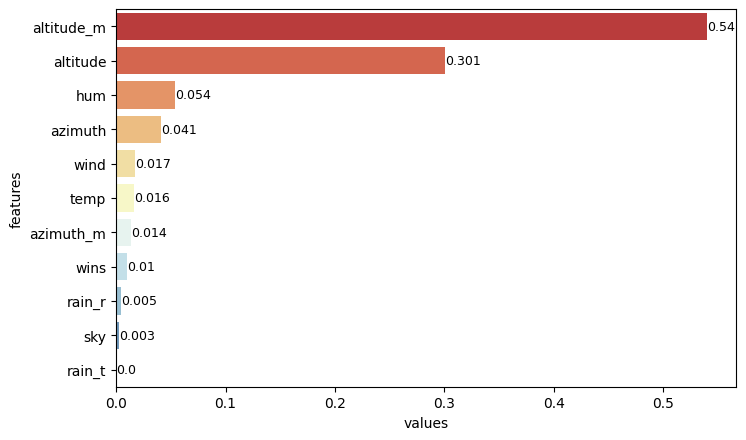

,result,testSVM,testgbr,testknn
datetime,,,,
2019-07-29 08:00:00,9.12,61.123333,40.826942,57.953554
2019-07-29 09:00:00,34.08,96.768809,62.909719,76.760353
2019-07-29 10:00:00,37.92,114.369846,67.299723,37.920000
2019-07-29 11:00:00,54.24,120.437680,80.093035,102.968847
2019-07-29 12:00:00,93.36,128.619255,91.604906,112.127128


In [63]:
df = svr_gbr('test', X_train, y_train, X_test, y_test,gbr_n=300)
df.head()

In [64]:
df168['svm'] = df['testSVM']['2019-08-06 08:00:00':]
df168['gbr'] = df['testgbr']['2019-08-06 08:00:00':]
df168.head()

,y,yhat,diff,day,month,svm,gbr
datetime,,,,,,,
2019-08-06 08:00:00,29.04,45.341019,8.717122,20190806,201908,16.091448,30.393571
2019-08-06 09:00:00,48.00,73.558403,13.667595,20190806,201908,29.337538,50.335630
2019-08-06 10:00:00,43.68,101.224884,30.772665,20190806,201908,43.880175,57.927024
2019-08-06 11:00:00,46.32,121.104118,39.991507,20190806,201908,56.180499,68.340281
2019-08-06 12:00:00,29.52,130.191574,53.835066,20190806,201908,66.057496,85.194294


In [131]:
import plotly.graph_objects as go

resample = df168['2020-05-01 00:00:00':]

f = go.FigureWidget()
f.add_scatter(y=resample['y']['2020-05-01 00:00:00':],x = resample.index, name = 'real_result');
f.add_scatter(y=resample['yhat']['2020-05-01 00:00:00':],x = resample.index,name = 'LSTM');
f.add_scatter(y=resample['svm']['2020-05-01 00:00:00':],x = resample.index,name = 'SVR');
f.add_scatter(y=resample['gbr']['2020-05-01 00:00:00':],x = resample.index,name = 'GBR');
f.update_layout(plot_bgcolor='white')
f.update_xaxes(showgrid=True, gridwidth=1, gridcolor='LightGrey')
f.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGrey')
f.update_xaxes(zeroline=True, zerolinewidth=1, zerolinecolor='LightGrey')
f.update_yaxes(zeroline=True, zerolinewidth=2, zerolinecolor='LightGrey')

f.show()

In [145]:
f.write_html('total_model.html')

In [18]:
#수익값 예측
def cal_result(x, name) :
 if x.y < 18.7 : return np.nan
 else :
   value = abs(x.y-x[name])/187*100
   return value


In [19]:
df168['svm_diff'] = df168.apply(lambda x : cal_result(x, 'svm'), axis=1)
df168['gbr_diff'] = df168.apply(lambda x : cal_result(x, 'gbr'), axis=1)
df168.head()

,y,yhat,diff,day,month,svm,gbr,svm_diff,gbr_diff
datetime,,,,,,,,,
2019-08-06 08:00:00,29.04,45.341019,8.717122,20190806,201908,16.091448,30.393571,6.924359,0.723835
2019-08-06 09:00:00,48.00,73.558403,13.667595,20190806,201908,29.337538,50.335630,9.979926,1.249000
2019-08-06 10:00:00,43.68,101.224884,30.772665,20190806,201908,43.880175,57.927024,0.107045,7.618730
2019-08-06 11:00:00,46.32,121.104118,39.991507,20190806,201908,56.180499,68.340281,5.272994,11.775551
2019-08-06 12:00:00,29.52,130.191574,53.835066,20190806,201908,66.057496,85.194294,19.538768,29.772350


In [21]:
plot_data = df168.groupby('month').agg({'diff' : 'mean','svm_diff' : 'mean','gbr_diff' : 'mean'})

In [24]:
import plotly.graph_objects as go

f = go.FigureWidget()
#f.add_scatter(y=plot_data['y'],x = plot_data.index, name = 'real_result');
f.add_scatter(y=plot_data['diff'],x = plot_data.index,name = 'LSTM');
f.add_scatter(y=plot_data['svm_diff'],x = plot_data.index,name = 'SVR');
f.add_scatter(y=plot_data['gbr_diff'],x = plot_data.index,name = 'GBR');
f.update_layout(plot_bgcolor='white')
f.update_xaxes(showgrid=True, gridwidth=1, gridcolor='LightGrey')
f.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGrey')
f.update_xaxes(zeroline=True, zerolinewidth=1, zerolinecolor='LightGrey')
f.update_yaxes(zeroline=True, zerolinewidth=2, zerolinecolor='LightGrey')

f.show()